# Grocery Sales Forecasting - Complete EDA & Feature Engineering

This notebook performs comprehensive data cleaning, merging, feature engineering, and exploratory data analysis for predicting 1-16 days ahead of unit_sales.

**Goal:** Prepare data for Item-Store Daily Forecasting model

**Strategy:** 
- Feature engineering on FULL 125M dataset
- Stratified sampling ONLY for visualizations (fast EDA)
- Final outputs include full engineered dataset for modeling

**Contents:**
1. Data Loading & Cleaning
2. Dataset Merging → **Save merged.csv**
3. Feature Engineering on FULL dataset (~30 features) → **Save featured.csv**
4. Stratified Sampling (2M rows for visualizations only)
5. 10 Essential Visualizations (on sample)
6. Train/Test Split (on full dataset) → **Save train.csv & test.csv**

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 1.24.3


## 2. Data Loading & Initial Cleaning

In [2]:
# Load all datasets
print("Loading datasets...")

df_train = pd.read_parquet('../data_science_project/data/raw/df_train_all_v1.parquet')
df_items = pd.read_parquet('../data_science_project/data/raw/items.parquet')
df_stores = pd.read_parquet('../data_science_project/data/raw/stores.parquet')
df_oil = pd.read_parquet('../data_science_project/data/raw/oil.parquet')
df_transactions = pd.read_parquet('../data_science_project/data/raw/transactions.parquet')
df_holidays = pd.read_parquet('../data_science_project/data/raw/holiday_events.parquet')

print(f"✓ Train data: {df_train.shape}")
print(f"✓ Items: {df_items.shape}")
print(f"✓ Stores: {df_stores.shape}")
print(f"✓ Oil: {df_oil.shape}")
print(f"✓ Transactions: {df_transactions.shape}")
print(f"✓ Holidays: {df_holidays.shape}")

# Display sample data
print("\n" + "="*50)
print("SAMPLE DATA:")
print("="*50)
print("\nTrain data:")
print(df_train.head(3))
print("\nItems:")
print(df_items.head(3))
print("\nStores:")
print(df_stores.head(3))

Loading datasets...
✓ Train data: (125497040, 5)
✓ Items: (4100, 3)
✓ Stores: (54, 4)
✓ Oil: (1218, 2)
✓ Transactions: (83488, 3)
✓ Holidays: (350, 6)

SAMPLE DATA:

Train data:
        date  store_nbr  item_nbr  unit_sales  onpromotion
0 2013-01-01         25    103665    2.079442        False
1 2013-01-01         25    105574    0.693147        False
2 2013-01-01         25    105575    1.098612        False

Items:
             family  class  perishable
item_nbr                              
96995     GROCERY I   1093           0
99197     GROCERY I   1067           0
103501     CLEANING   3008           0

Stores:
            city      state type  cluster
store_nbr                                
1          Quito  Pichincha    D       13
2          Quito  Pichincha    D       13
3          Quito  Pichincha    D        8


### 2.1 Filter to Single Store (Memory Optimization)

In [3]:
# print("=" * 70)
# print("FILTERING TO SINGLE STORE FOR MEMORY OPTIMIZATION")
# print("=" * 70)
# print(f"Original data shape: {df_train.shape}")
# print(f"Memory usage before: {df_train.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

# # Filter to store_nbr = 1 only
# df_train = df_train[df_train['store_nbr'] == 5].copy()
# df_transactions = df_transactions[df_transactions['store_nbr'] == 1].copy()

# print(f"\n✓ Filtered to store_nbr = 1")
# print(f"New data shape: {df_train.shape}")
# print(f"Memory usage after: {df_train.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
# print(f"Reduction: ~{(1 - len(df_train) / 125497040) * 100:.1f}% fewer rows")
# print(f"Memory saved: Significant reduction for single-store analysis")
# print("=" * 70)

### 2.2 Convert Log-Transformed Unit Sales to Original Scale

In [4]:
print("Converting log-transformed unit_sales to original scale...")
print(f"Before conversion - unit_sales stats:")
print(f"  Mean: {df_train['unit_sales'].mean():.4f}")
print(f"  Median: {df_train['unit_sales'].median():.4f}")
print(f"  Max: {df_train['unit_sales'].max():.4f}")
print(f"  Min: {df_train['unit_sales'].min():.4f}")

# Apply inverse log transformation: exp(x) - 1
# Original transformation was: log(x + 1), so inverse is: exp(x) - 1
df_train['unit_sales'] = np.expm1(df_train['unit_sales'])

print(f"\n✓ Conversion complete!")
print(f"After conversion - unit_sales stats:")
print(f"  Mean: {df_train['unit_sales'].mean():.2f}")
print(f"  Median: {df_train['unit_sales'].median():.2f}")
print(f"  Max: {df_train['unit_sales'].max():.2f}")
print(f"  Min: {df_train['unit_sales'].min():.2f}")

print(f"\n✓ All features will now be created on ORIGINAL SCALE (not log-transformed)")

Converting log-transformed unit_sales to original scale...
Before conversion - unit_sales stats:
  Mean: 1.7509
  Median: 1.6094
  Max: 11.4013
  Min: 0.0000

✓ Conversion complete!
After conversion - unit_sales stats:
  Mean: 8.56
  Median: 4.00
  Max: 89440.00
  Min: 0.00

✓ All features will now be created on ORIGINAL SCALE (not log-transformed)


### 2.3 Convert Date Columns to Datetime

In [5]:
print("Converting date columns to datetime...")

# Convert date columns
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

print("✓ All date columns converted to datetime")
print(f"\nDate ranges:")
print(f"Train: {df_train['date'].min()} to {df_train['date'].max()}")
print(f"Oil: {df_oil['date'].min()} to {df_oil['date'].max()}")
print(f"Transactions: {df_transactions['date'].min()} to {df_transactions['date'].max()}")
print(f"Holidays: {df_holidays['date'].min()} to {df_holidays['date'].max()}")

Converting date columns to datetime...
✓ All date columns converted to datetime

Date ranges:
Train: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Oil: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Transactions: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Holidays: 2012-03-02 00:00:00 to 2017-12-26 00:00:00


### 2.4 Interpolate Missing Oil Prices (43 values)

In [6]:
print("Handling missing oil prices...")
print(f"Missing oil prices before: {df_oil['dcoilwtico'].isna().sum()}")

# Linear interpolation
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

# Forward fill for any remaining
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')

# Backward fill for any at the beginning
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

print(f"Missing oil prices after: {df_oil['dcoilwtico'].isna().sum()}")
print("✓ Oil prices interpolated successfully")

Handling missing oil prices...
Missing oil prices before: 43
Missing oil prices after: 0
✓ Oil prices interpolated successfully


## 3. Dataset Merging (Sequential Order)

In [7]:
print("Merging datasets in order...")
print(f"Starting with train data: {df_train.shape}")

# Step 1: Merge items
df = df_train.merge(df_items, on='item_nbr', how='left')
print(f"After merging items: {df.shape}")

# Step 2: Merge stores
df = df.merge(df_stores, on='store_nbr', how='left')
print(f"After merging stores: {df.shape}")

# Step 3: Merge oil
df = df.merge(df_oil, on='date', how='left')
print(f"After merging oil: {df.shape}")

# Step 4: Merge transactions
df = df.merge(df_transactions, on=['date', 'store_nbr'], how='left')
print(f"After merging transactions: {df.shape}")

# Step 5: Merge holidays - create holiday flags
df_holidays_clean = df_holidays.copy()
df_holidays_clean['is_holiday'] = 1
# Keep only necessary columns from holidays
holidays_agg = df_holidays_clean.groupby('date').agg({
    'is_holiday': 'max',
    'type': lambda x: ', '.join(x.unique()),
    'transferred': 'max'
}).reset_index()
holidays_agg.columns = ['date', 'is_holiday', 'holiday_type', 'holiday_transferred']

df = df.merge(holidays_agg, on='date', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)
print(f"After merging holidays: {df.shape}")

print(f"\n✓ Final merged dataset: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Merging datasets in order...
Starting with train data: (125497040, 5)
After merging items: (125497040, 8)
After merging stores: (125497040, 12)
After merging oil: (125497040, 13)
After merging transactions: (125497040, 14)
After merging holidays: (125497040, 17)

✓ Final merged dataset: (125497040, 17)

Columns: ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family', 'class', 'perishable', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'transactions', 'is_holiday', 'holiday_type', 'holiday_transferred']


### 3.1 Save Merged Dataset

In [8]:
print("Saving merged dataset...")

# Save merged dataset (full 125M rows)
output_path = '../data_science_project/results/df_merged.parquet'
df.to_parquet(output_path, index=False)

print(f"✓ Merged dataset saved to: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  Size on disk: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB in memory")

Saving merged dataset...
✓ Merged dataset saved to: ../data_science_project/results/df_merged.parquet
  Shape: (125497040, 17)
  Size on disk: 48326.7 MB in memory


## 4. Feature Engineering on FULL Dataset (~30 Features)

**IMPORTANT:** All feature engineering is performed on the full 125M row dataset to ensure production-ready features.

In [9]:
print("Adding year column for feature engineering...")

# Add year column (needed for temporal features)
df['year'] = df['date'].dt.year

print(f"✓ Year column added")
print(f"✓ Working with FULL dataset: {df.shape}")

Adding year column for feature engineering...
✓ Year column added
✓ Working with FULL dataset: (125497040, 18)


### 4.1 Temporal Features (8 features)

In [10]:
print("Creating temporal features...")

# Temporal features
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

temporal_features = ['year', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 
                     'is_weekend', 'is_month_start', 'is_month_end']

print(f"✓ Created {len(temporal_features)} temporal features")
print(f"Features: {temporal_features}")

Creating temporal features...
✓ Created 8 temporal features
Features: ['year', 'month', 'day_of_week', 'day_of_month', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end']


### 4.2 Lag Features (4 features)
Creating lags grouped by (store_nbr, item_nbr) to prevent data leakage.

In [11]:
print("Creating lag features (grouped by store_nbr, item_nbr)...")
print("This may take 5-10 minutes for 125M rows...")

# Sort by store, item, and date (only once)
print("  Sorting dataset...")
df = df.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

# Create lag features (these are relatively fast with groupby)
print("  Creating lag_1...")
df['sales_lag_1'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
print("  Creating lag_7...")
df['sales_lag_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
print("  Creating lag_14...")
df['sales_lag_14'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(14)
print("  Creating lag_28...")
df['sales_lag_28'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(28)

print(f"Missing values in lag_1 (expected for first days): {df['sales_lag_1'].isna().sum():,}")

lag_features = ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28']

print(f"Features: {lag_features}")
print(f"✓ Created {len(lag_features)} lag features")

Creating lag features (grouped by store_nbr, item_nbr)...
This may take 5-10 minutes for 125M rows...
  Sorting dataset...
  Creating lag_1...
  Creating lag_7...
  Creating lag_14...
  Creating lag_28...
Missing values in lag_1 (expected for first days): 174,685
Features: ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28']
✓ Created 4 lag features


### 4.3 Rolling Statistics (6 features)
Creating rolling windows grouped by (store_nbr, item_nbr).

In [12]:
print("Creating rolling statistics features...")
print("⚠️  WARNING: This is MEMORY-INTENSIVE and may take 10-20 minutes")
print("   Consider using only essential rolling features to reduce runtime")

# Rolling windows (using shift to prevent data leakage)
print("  Creating rolling_mean_7...")
df['rolling_mean_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean())

print("  Creating rolling_mean_14...")
df['rolling_mean_14'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=14, min_periods=1).mean())

print("  Creating rolling_mean_28...")
df['rolling_mean_28'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=28, min_periods=1).mean())

print("  Creating rolling_std_7...")
df['rolling_std_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).std())

print("  Creating rolling_max_7...")
df['rolling_max_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).max())

print("  Creating rolling_min_7...")
df['rolling_min_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).min())

import gc
# Free memory
gc.collect()

rolling_features = ['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 

                    'rolling_std_7', 'rolling_max_7', 'rolling_min_7']

print(f"Features: {rolling_features}")
print(f"✓ Created {len(rolling_features)} rolling features")

Creating rolling statistics features...
⚠️  WARNING: This is MEMORY-INTENSIVE and may take 10-20 minutes
   Consider using only essential rolling features to reduce runtime
  Creating rolling_mean_7...
  Creating rolling_mean_14...
  Creating rolling_mean_28...
  Creating rolling_std_7...
  Creating rolling_max_7...
  Creating rolling_min_7...
Features: ['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7']
✓ Created 6 rolling features


### 4.4 Holiday Features (3 features)

In [13]:
print("Creating holiday features...")

# Simple approach: only use is_holiday and is_before_holiday
# Create is_before_holiday by checking if next 1-3 days are holidays
df_sorted = df.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

# Check if any of the next 3 days is a holiday (for same store-item)
df_sorted['is_before_holiday'] = 0
for i in range(1, 4):
    next_day_holiday = df_sorted.groupby(['store_nbr', 'item_nbr'])['is_holiday'].shift(-i)
    df_sorted['is_before_holiday'] = df_sorted['is_before_holiday'] | next_day_holiday.fillna(0).astype(int)

# Restore original order
df['is_before_holiday'] = df_sorted.sort_index()['is_before_holiday'].values

holiday_features = ['is_holiday', 'is_before_holiday']

print(f"✓ Created {len(holiday_features)} holiday features")
print(f"Features: {holiday_features}")
print(f"Total holidays: {df['is_holiday'].sum():,}")
print(f"Days before holidays: {df['is_before_holiday'].sum():,}")

# Free memory
del df_sorted
import gc
gc.collect()

Creating holiday features...
✓ Created 2 holiday features
Features: ['is_holiday', 'is_before_holiday']
Total holidays: 19,354,991
Days before holidays: 39,464,289


0

### 4.5 Promotion Features (3 features)

In [14]:
print("Creating promotion features...")

# Ensure onpromotion is binary
df['onpromotion'] = df['onpromotion'].fillna(0).astype(int)

# Promo lag (was there a promotion 7 days ago?)
df['promo_lag_7'] = df.groupby(['store_nbr', 'item_nbr'])['onpromotion'].shift(7)

# Days since last promotion
df_temp = df[df['onpromotion'] == 1][['store_nbr', 'item_nbr', 'date']].copy()
df_temp = df_temp.rename(columns={'date': 'last_promo_date'})

df = df.merge(
    df_temp.groupby(['store_nbr', 'item_nbr'])['last_promo_date'].max().reset_index(),
    on=['store_nbr', 'item_nbr'],
    how='left'
)

df['days_since_promo'] = (df['date'] - df['last_promo_date']).dt.days
df['days_since_promo'] = df['days_since_promo'].fillna(999)  # Never had promotion

# Promotion frequency in last 30 days
df['promo_frequency_30'] = df.groupby(['store_nbr', 'item_nbr'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(window=30, min_periods=1).sum()
)

# Clean up
df = df.drop('last_promo_date', axis=1)

promo_features = ['promo_lag_7', 'days_since_promo', 'promo_frequency_30']

print(f"✓ Created {len(promo_features)} promotion features")
print(f"Features: {promo_features}")
print(f"Items on promotion: {df['onpromotion'].sum():,} ({df['onpromotion'].mean()*100:.1f}%)")

Creating promotion features...
✓ Created 3 promotion features
Features: ['promo_lag_7', 'days_since_promo', 'promo_frequency_30']
Items on promotion: 7,810,622 (6.2%)


### 4.6 Aggregate Features (4 features)

In [15]:
print("Creating aggregate features...")
print("This may take 5-10 minutes...")

# Store daily sales (total sales across all items in that store on that day)
print("  Creating store_daily_sales...")
store_daily = df.groupby(['store_nbr', 'date'])['unit_sales'].sum().reset_index()
store_daily.columns = ['store_nbr', 'date', 'store_daily_sales']
df = df.merge(store_daily, on=['store_nbr', 'date'], how='left')
del store_daily

# Item daily sales (total sales of that item across all stores on that day)
print("  Creating item_daily_sales...")
item_daily = df.groupby(['item_nbr', 'date'])['unit_sales'].sum().reset_index()
item_daily.columns = ['item_nbr', 'date', 'item_daily_sales']
df = df.merge(item_daily, on=['item_nbr', 'date'], how='left')
del item_daily

# Family average sales (using expanding window to prevent leakage)
print("  Creating family_avg_sales (sorting by family, date)...")
df = df.sort_values(['family', 'date']).reset_index(drop=True)
df['family_avg_sales'] = df.groupby('family')['unit_sales'].transform(lambda x: x.shift(1).expanding().mean())

# Store-family average sales
print("  Creating store_family_avg_sales (sorting by store, family, date)...")
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
df['store_family_avg_sales'] = df.groupby(['store_nbr', 'family'])['unit_sales'].transform(lambda x: x.shift(1).expanding().mean())

import gc
# Free memory
gc.collect()

aggregate_features = ['store_daily_sales', 'item_daily_sales', 'family_avg_sales', 'store_family_avg_sales']

print(f"Features: {aggregate_features}")
print(f"✓ Created {len(aggregate_features)} aggregate features")

Creating aggregate features...
This may take 5-10 minutes...
  Creating store_daily_sales...
  Creating item_daily_sales...
  Creating family_avg_sales (sorting by family, date)...
  Creating store_family_avg_sales (sorting by store, family, date)...
Features: ['store_daily_sales', 'item_daily_sales', 'family_avg_sales', 'store_family_avg_sales']
✓ Created 4 aggregate features


### 4.7 Interaction Features (3 features)

In [16]:
print("Creating interaction features...")

# Promotion on weekend
df['promo_weekend'] = df['onpromotion'] * df['is_weekend']

# Perishable on weekend
df['perishable_weekend'] = df['perishable'] * df['is_weekend']

# Holiday with promotion
df['holiday_promo'] = df['is_holiday'] * df['onpromotion']

interaction_features = ['promo_weekend', 'perishable_weekend', 'holiday_promo']

print(f"✓ Created {len(interaction_features)} interaction features")
print(f"Features: {interaction_features}")

Creating interaction features...
✓ Created 3 interaction features
Features: ['promo_weekend', 'perishable_weekend', 'holiday_promo']


### 4.8 Feature Engineering Summary & Save

In [17]:
print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

all_engineered_features = (temporal_features + lag_features + rolling_features + 
                           holiday_features + promo_features + aggregate_features + 
                           interaction_features)

print(f"\nTotal engineered features: {len(all_engineered_features)}")
print(f"\nBreakdown:")
print(f"  - Temporal: {len(temporal_features)}")
print(f"  - Lag: {len(lag_features)}")
print(f"  - Rolling: {len(rolling_features)}")
print(f"  - Holiday: {len(holiday_features)}")
print(f"  - Promotion: {len(promo_features)}")
print(f"  - Aggregate: {len(aggregate_features)}")
print(f"  - Interaction: {len(interaction_features)}")

print(f"\nFull dataset shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")

# Display sample with new features
print("\nSample of engineered features:")
feature_cols = ['date', 'store_nbr', 'item_nbr', 'unit_sales'] + all_engineered_features[:10]
print(df[feature_cols].head())

# Save full featured dataset
print("\n" + "="*60)
print("SAVING FULL FEATURED DATASET")
print("="*60)

output_path = '../data_science_project/results/df_featured_full.parquet'
df.to_parquet(output_path, index=False)

print(f"✓ Full featured dataset saved to: {output_path}")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")
print(f"  Ready for modeling!")

FEATURE ENGINEERING SUMMARY

Total engineered features: 30

Breakdown:
  - Temporal: 8
  - Lag: 4
  - Rolling: 6
  - Holiday: 2
  - Promotion: 3
  - Aggregate: 4
  - Interaction: 3

Full dataset shape: (125497040, 46)
Total columns: 46

Sample of engineered features:
        date  store_nbr  item_nbr  unit_sales  year  month  day_of_week  \
0 2013-01-02          1    121964         1.0  2013      1            2   
1 2013-01-02          1    270522         1.0  2013      1            2   
2 2013-01-03          1    461432         3.0  2013      1            3   
3 2013-01-04          1    461432         1.0  2013      1            4   
4 2013-01-04          1   1118683         2.0  2013      1            4   

   day_of_month  week_of_year  is_weekend  is_month_start  is_month_end  \
0             2             1           0               0             0   
1             2             1           0               0             0   
2             3             1           0               

## 5. Create Stratified Sample (2M rows - FOR VISUALIZATIONS ONLY)

In [18]:
print("Creating stratified sample for VISUALIZATIONS ONLY...")
print("(Full dataset preserved for final modeling)")

# Create stratification key
df['strata'] = df['year'].astype(str) + '_' + df['family'] + '_' + df['type']

# Calculate sample size per stratum
n_sample = 2_000_000
total_rows = len(df)
sample_fraction = n_sample / total_rows

print(f"\nFull dataset: {total_rows:,} rows")
print(f"Sample size: {n_sample:,} rows")
print(f"Sample fraction: {sample_fraction:.4f}")

# Stratified sampling
df_sample = df.groupby('strata', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42) if len(x) > 1 else x
).reset_index(drop=True)

print(f"\n✓ Sample created: {df_sample.shape}")
print(f"\nYears distribution in sample:")
print(df_sample['year'].value_counts().sort_index())
print(f"\nFamilies in sample: {df_sample['family'].nunique()}")
print(f"Store types in sample: {df_sample['type'].nunique()}")

# Save sample for future visualization
output_path = '../data_science_project/results/df_sample_2m.parquet'
df_sample.to_parquet(output_path, index=False)
print(f"\n✓ Sample saved to: {output_path}")

print("\n" + "="*60)
print("⚠️  IMPORTANT: Sample is ONLY for visualizations below")
print("⚠️  Full dataset (df) is preserved for final train/test split")
print("="*60)

Creating stratified sample for VISUALIZATIONS ONLY...
(Full dataset preserved for final modeling)

Full dataset: 125,497,040 rows
Sample size: 2,000,000 rows
Sample fraction: 0.0159

✓ Sample created: (2000011, 47)

Years distribution in sample:
year
2013    260128
2014    354934
2015    444070
2016    561449
2017    379430
Name: count, dtype: int64

Families in sample: 33
Store types in sample: 5

✓ Sample saved to: ../data_science_project/results/df_sample_2m.parquet

⚠️  IMPORTANT: Sample is ONLY for visualizations below
⚠️  Full dataset (df) is preserved for final train/test split


## 6. Exploratory Data Analysis - 10 Essential Visualizations (on 2M sample)

### Visualization 1: Daily Aggregate Sales Trend (2013-2017)

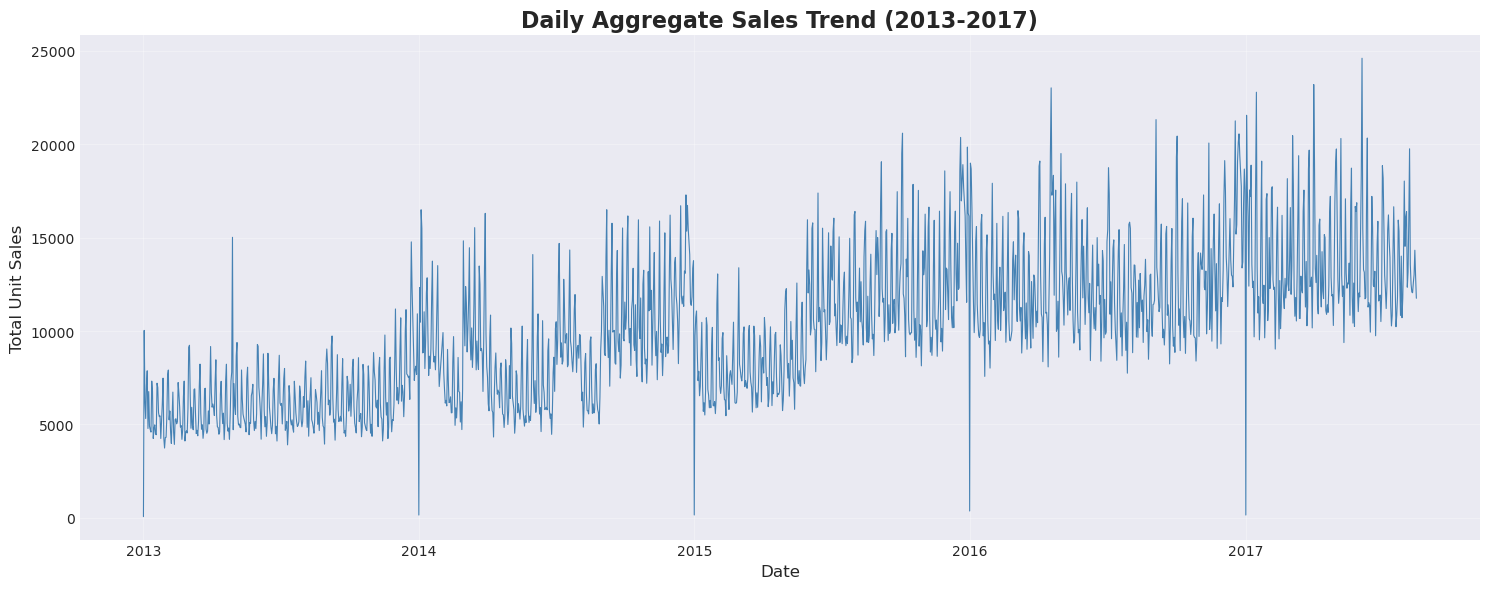

Overall trend: Min=64.00, Max=24599.00, Mean=10153.38


In [31]:
plt.figure(figsize=(15, 6))

daily_sales = df_sample.groupby('date')['unit_sales'].sum().reset_index()
plt.plot(daily_sales['date'], daily_sales['unit_sales'], linewidth=0.8, color='steelblue')
plt.title('Daily Aggregate Sales Trend (2013-2017)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Unit Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Overall trend: Min={daily_sales['unit_sales'].min():.2f}, Max={daily_sales['unit_sales'].max():.2f}, Mean={daily_sales['unit_sales'].mean():.2f}")

### Visualization 2: Unit Sales Distribution

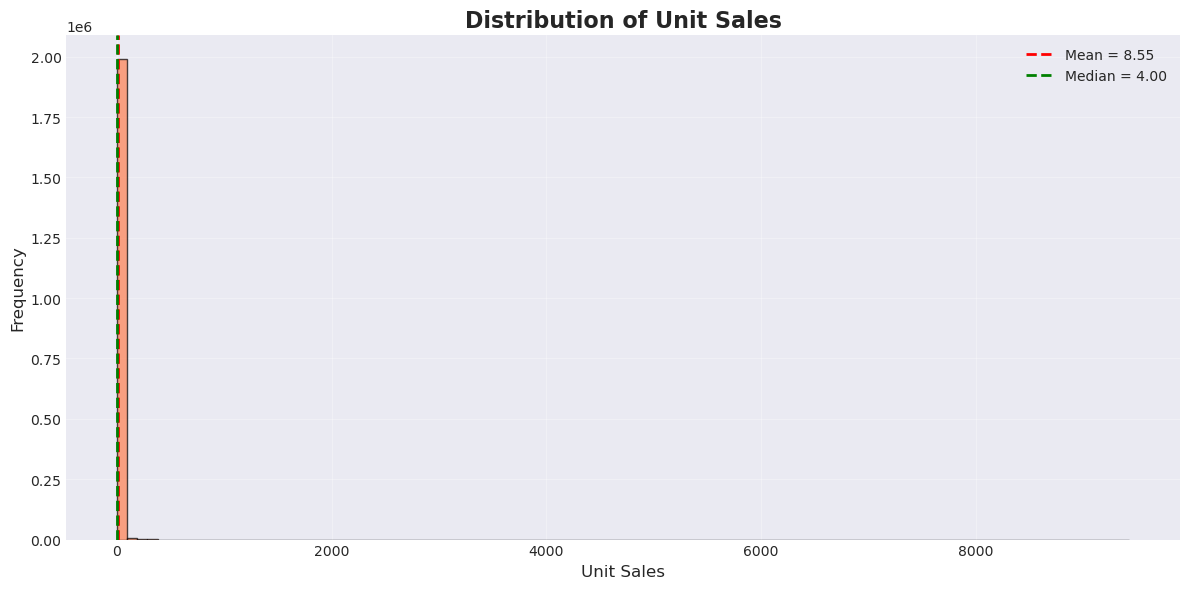

Statistics: Mean=8.55, Median=4.00, Std=22.11


In [20]:
plt.figure(figsize=(12, 6))

plt.hist(df_sample['unit_sales'], bins=100, edgecolor='black', alpha=0.7, color='coral')
plt.title('Distribution of Unit Sales', fontsize=16, fontweight='bold')
plt.xlabel('Unit Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df_sample['unit_sales'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_sample["unit_sales"].mean():.2f}')
plt.axvline(df_sample['unit_sales'].median(), color='green', linestyle='--', linewidth=2, label=f'Median = {df_sample["unit_sales"].median():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Statistics: Mean={df_sample['unit_sales'].mean():.2f}, Median={df_sample['unit_sales'].median():.2f}, Std={df_sample['unit_sales'].std():.2f}")

### Visualization 3: Average Sales by Product Family

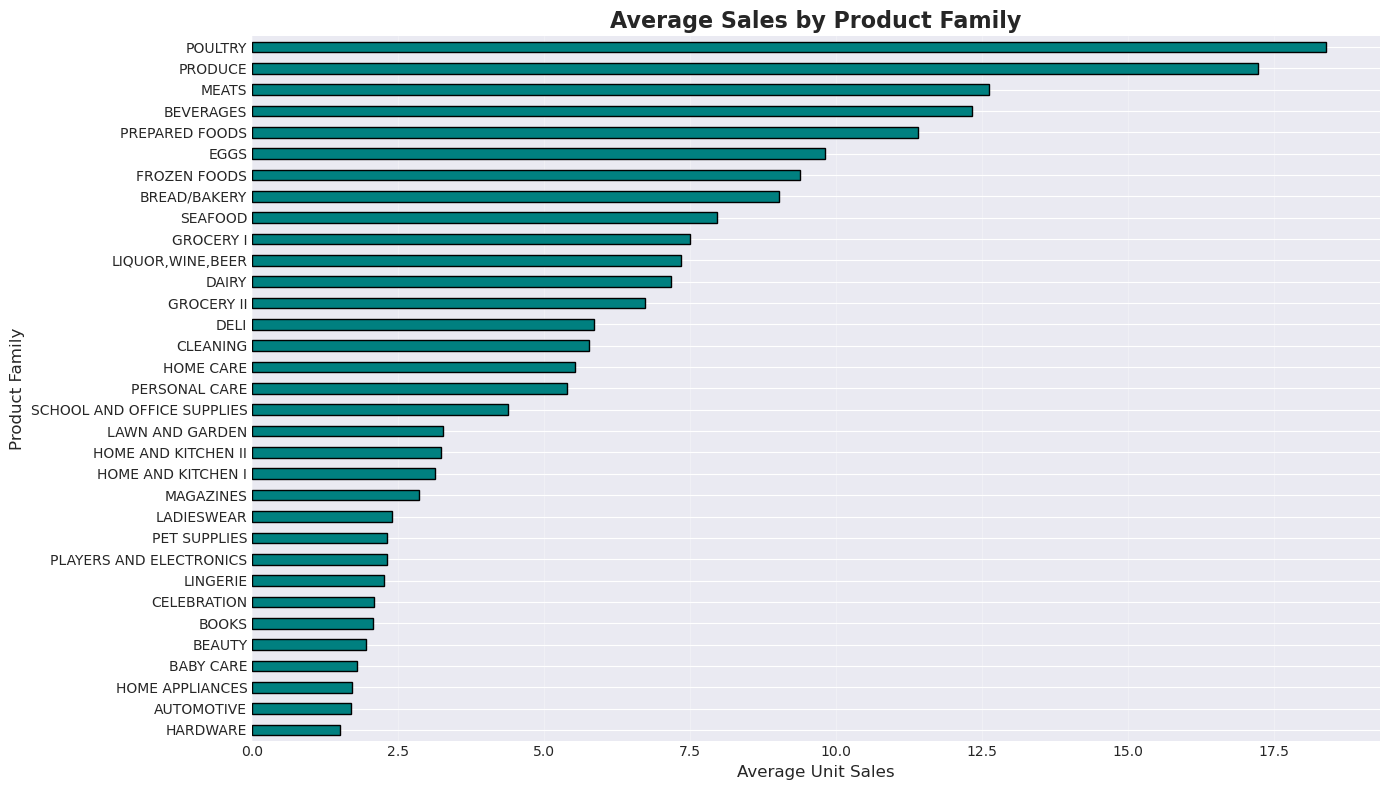

Top 5 families by average sales:
family
PREPARED FOODS    11.406952
BEVERAGES         12.326488
MEATS             12.620042
PRODUCE           17.232424
POULTRY           18.398098
Name: unit_sales, dtype: float64


In [21]:
plt.figure(figsize=(14, 8))

family_sales = df_sample.groupby('family')['unit_sales'].mean().sort_values(ascending=True)
family_sales.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Average Sales by Product Family', fontsize=16, fontweight='bold')
plt.xlabel('Average Unit Sales', fontsize=12)
plt.ylabel('Product Family', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"Top 5 families by average sales:")
print(family_sales.tail())

### Visualization 4: Promotion Impact (On vs Off)

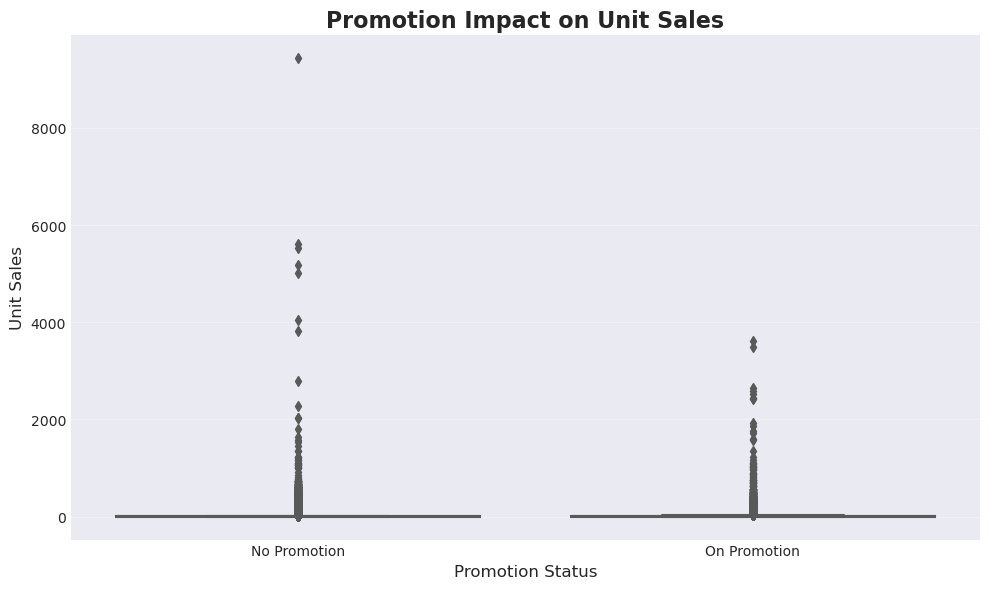


Promotion Statistics:
                  mean  median    count
onpromotion                            
0             8.223452     4.0  1875733
1            13.464165     6.0   124278


In [22]:
plt.figure(figsize=(10, 6))

df_sample['promo_status'] = df_sample['onpromotion'].map({0: 'No Promotion', 1: 'On Promotion'})
sns.boxplot(data=df_sample, x='promo_status', y='unit_sales', palette='Set2')
plt.title('Promotion Impact on Unit Sales', fontsize=16, fontweight='bold')
plt.xlabel('Promotion Status', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

promo_stats = df_sample.groupby('onpromotion')['unit_sales'].agg(['mean', 'median', 'count'])
print("\nPromotion Statistics:")
print(promo_stats)

### Visualization 5: Day-of-Week Seasonality

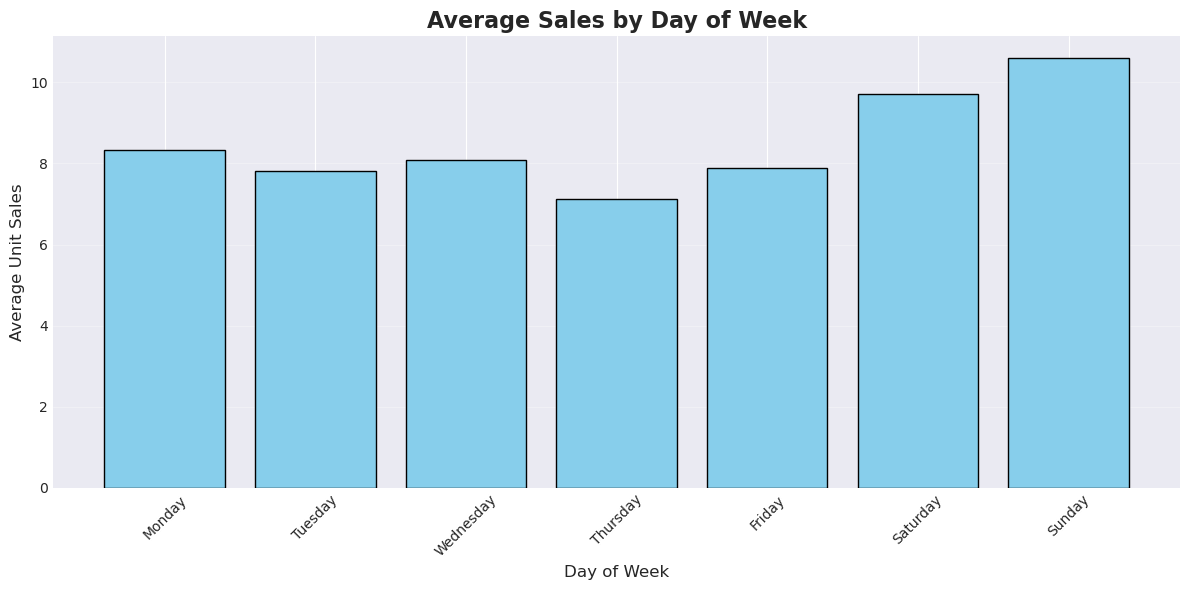


Day of Week Statistics:
day_of_week
0     8.337938
1     7.809296
2     8.091899
3     7.133978
4     7.884808
5     9.718511
6    10.603913
Name: unit_sales, dtype: float64


In [35]:
plt.figure(figsize=(12, 6))

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = df_sample.groupby('day_of_week')['unit_sales'].mean()
plt.bar(range(7), dow_sales.values, color='skyblue', edgecolor='black')
plt.xticks(range(7), day_names, rotation=45)
plt.title('Average Sales by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Unit Sales', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDay of Week Statistics:")
print(dow_sales)

### Visualization 6: Autocorrelation Plot (Lags 1-30)

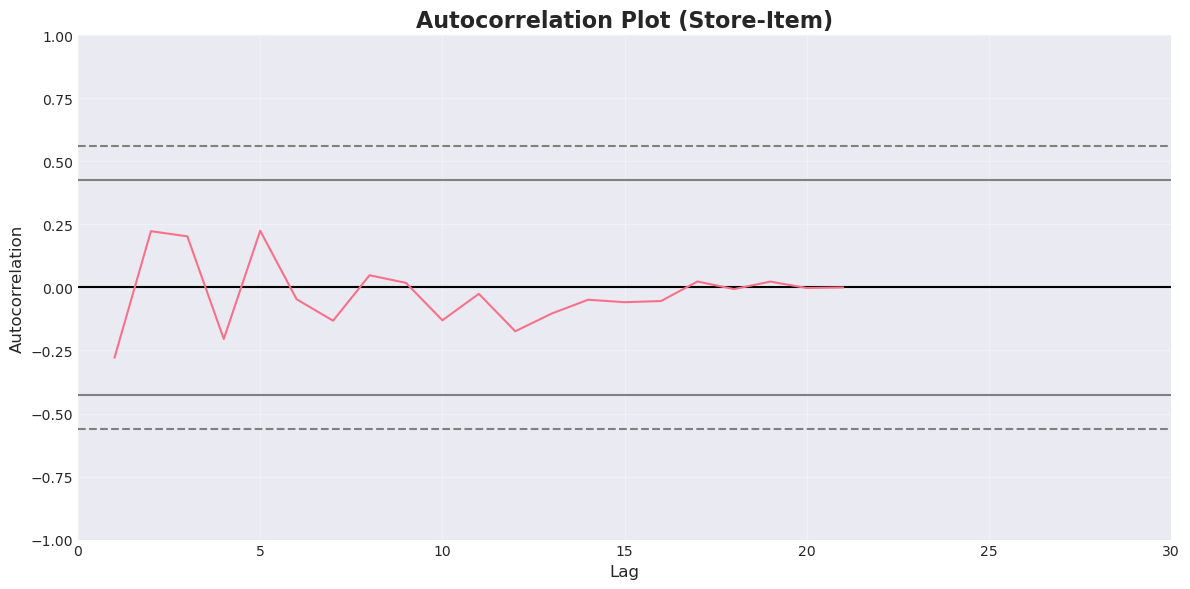

Key lags show strong correlation at 1, 7, 14 days (weekly patterns)


In [32]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 6))

# Sample a single store-item combination for autocorrelation
sample_series = df_sample[(df_sample['store_nbr'] == df_sample['store_nbr'].iloc[0]) & 
                   (df_sample['item_nbr'] == df_sample['item_nbr'].iloc[0])].sort_values('date')['unit_sales']

autocorrelation_plot(sample_series)
plt.title('Autocorrelation Plot (Store-Item)', fontsize=16, fontweight='bold')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.xlim(0, 30)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key lags show strong correlation at 1, 7, 14 days (weekly patterns)")

### Visualization 7: Rolling Mean Illustration

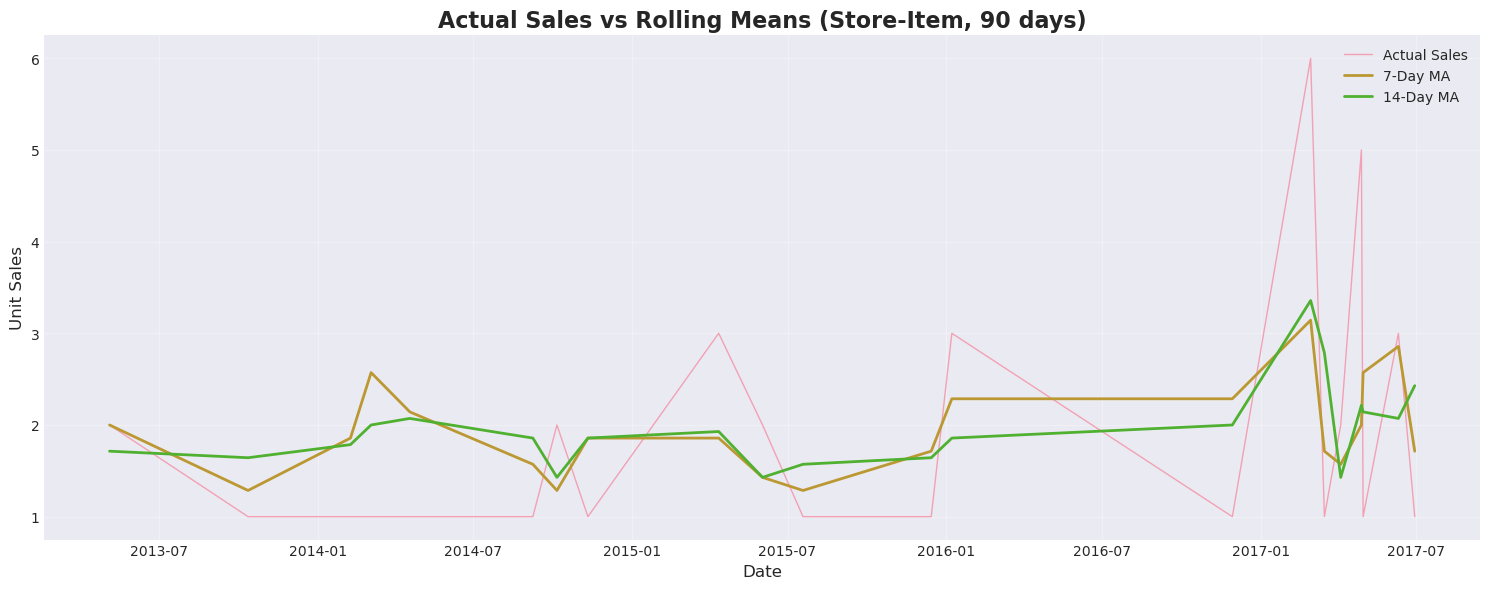

Rolling means smooth out daily volatility and capture trends


In [33]:
plt.figure(figsize=(15, 6))

# Select one store-item for visualization
visualization_df = df_sample[(df_sample['store_nbr'] == df_sample['store_nbr'].iloc[0]) & 
               (df_sample['item_nbr'] == df_sample['item_nbr'].iloc[0])].sort_values('date').head(90)

plt.plot(visualization_df['date'], visualization_df['unit_sales'], label='Actual Sales', alpha=0.6, linewidth=1)
plt.plot(visualization_df['date'], visualization_df['rolling_mean_7'], label='7-Day MA', linewidth=2)
plt.plot(visualization_df['date'], visualization_df['rolling_mean_14'], label='14-Day MA', linewidth=2)

plt.title('Actual Sales vs Rolling Means (Store-Item, 90 days)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Rolling means smooth out daily volatility and capture trends")

### Visualization 8: Holiday Effect

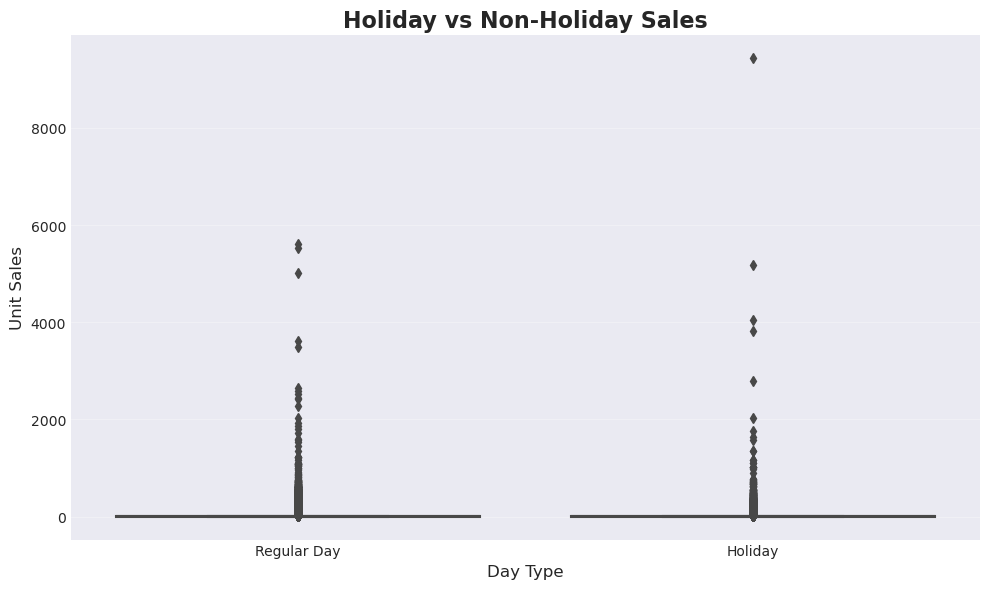


Holiday Statistics:
                mean  median    count
is_holiday                           
0           8.455172     4.0  1691728
1           9.064556     4.0   308283


In [26]:
plt.figure(figsize=(10, 6))

df_sample['holiday_status'] = df_sample['is_holiday'].map({0: 'Regular Day', 1: 'Holiday'})
sns.boxplot(data=df_sample, x='holiday_status', y='unit_sales', palette='Set1')
plt.title('Holiday vs Non-Holiday Sales', fontsize=16, fontweight='bold')
plt.xlabel('Day Type', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

holiday_stats = df_sample.groupby('is_holiday')['unit_sales'].agg(['mean', 'median', 'count'])
print("\nHoliday Statistics:")
print(holiday_stats)

### Visualization 9: Perishable vs Non-Perishable Patterns

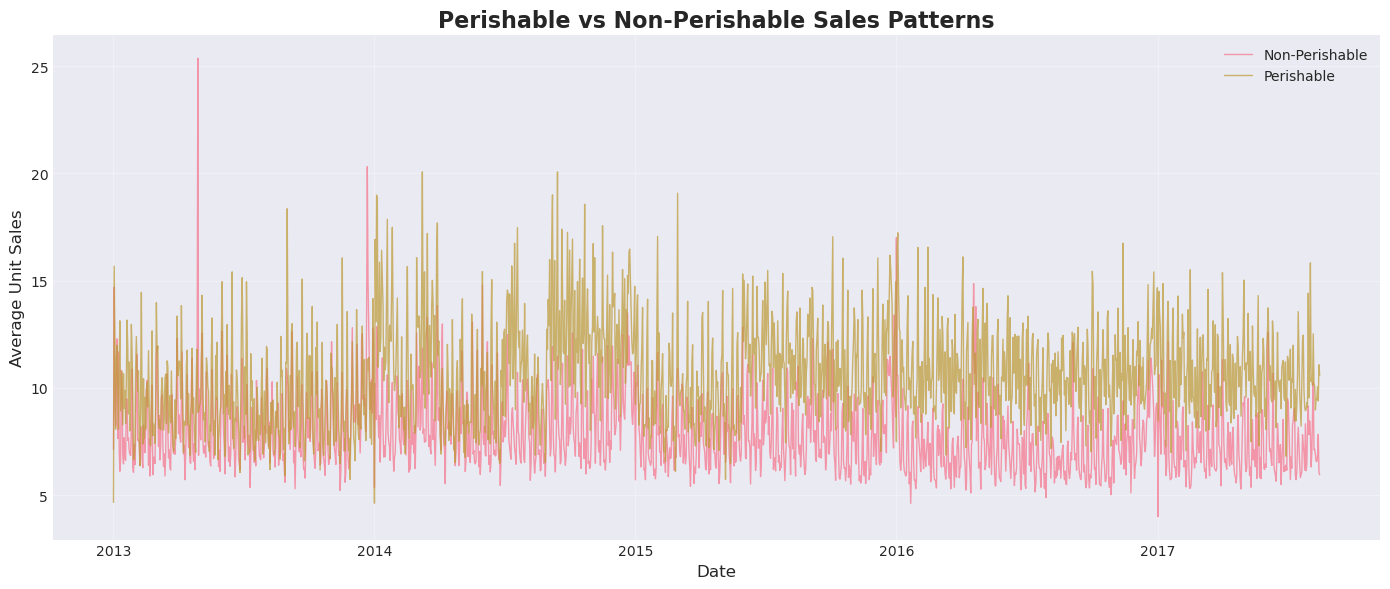


Perishable vs Non-Perishable Statistics:
                 mean        std    count
perishable                               
0            7.781668  22.304560  1494774
1           10.819605  21.358156   505237


In [ ]:
plt.figure(figsize=(14, 6))

perishable_daily = df_sample.groupby(['date', 'perishable'])['unit_sales'].mean().reset_index()

for p in [0, 1]:
    data = perishable_daily[perishable_daily['perishable'] == p]
    label = 'Non-Perishable' if p == 0 else 'Perishable'
    plt.plot(data['date'], data['unit_sales'], label=label, alpha=0.7, linewidth=1)

plt.title('Perishable vs Non-Perishable Sales Patterns', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Unit Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

perishable_stats = df_sample.groupby('perishable')['unit_sales'].agg(['mean', 'std', 'count'])
print("\nPerishable vs Non-Perishable Statistics:")
print(perishable_stats)
print('')

### Visualization 10: Feature Correlation Heatmap (Top 20 Features)

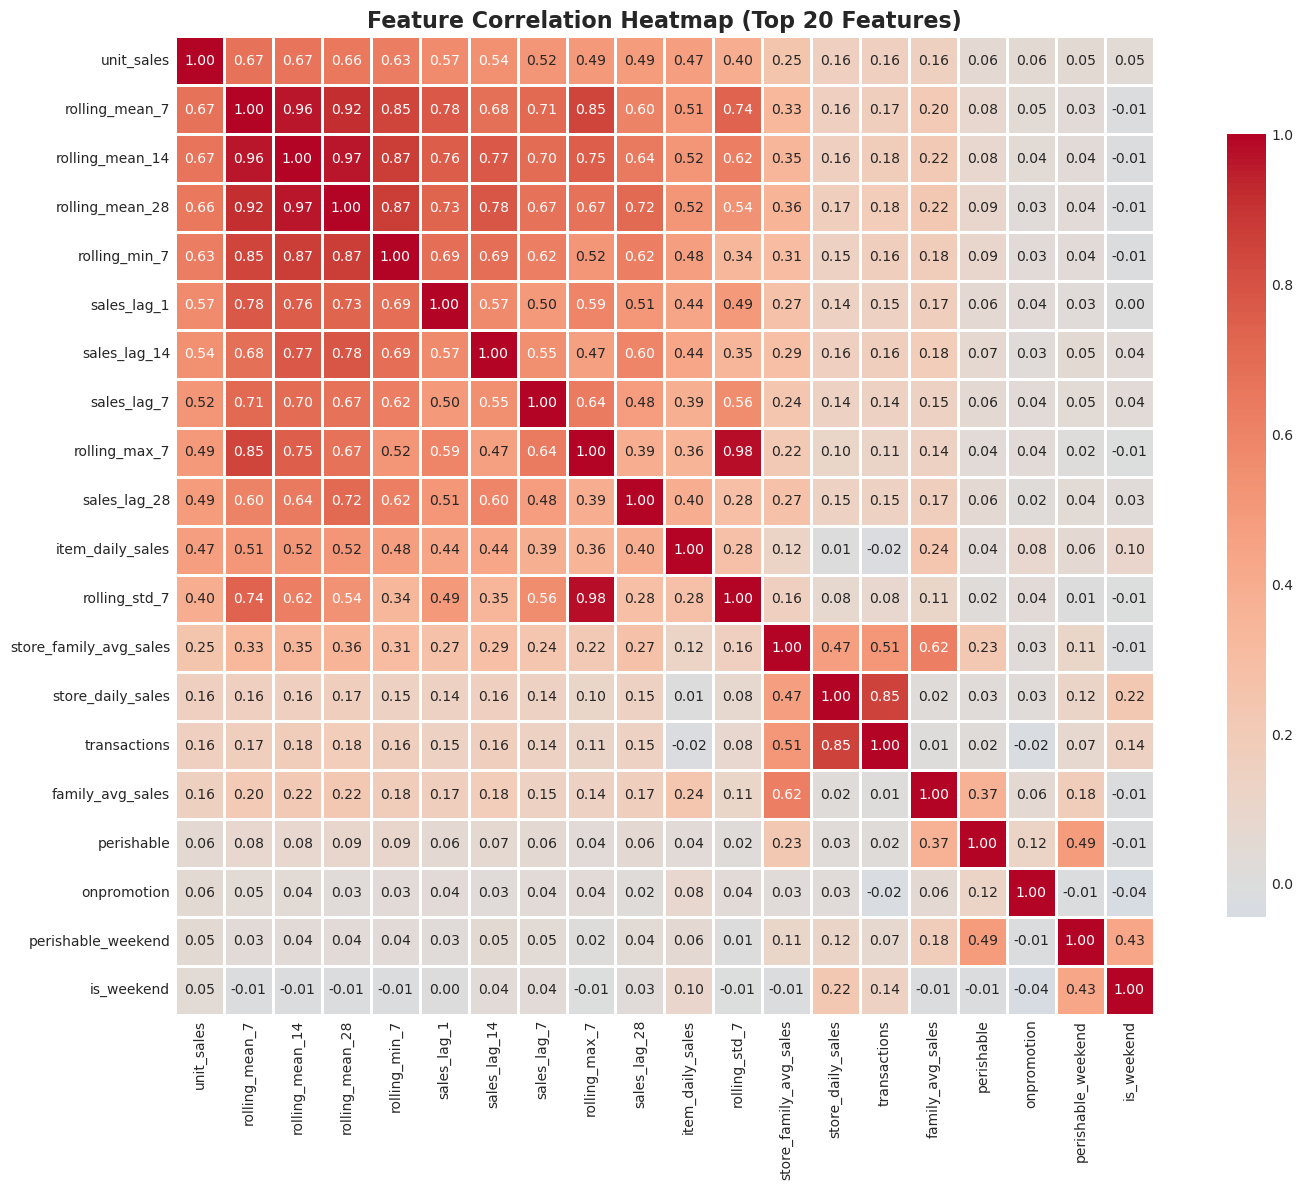


Top 10 Features Correlated with Unit Sales:
unit_sales         1.000000
rolling_mean_7     0.671948
rolling_mean_14    0.669381
rolling_mean_28    0.657046
rolling_min_7      0.625395
sales_lag_1        0.569536
sales_lag_14       0.540941
sales_lag_7        0.518759
rolling_max_7      0.494522
sales_lag_28       0.489284
Name: unit_sales, dtype: float64


In [28]:
plt.figure(figsize=(16, 12))

# Select numeric features for correlation
numeric_features = ['unit_sales'] + all_engineered_features + ['onpromotion', 'perishable', 
                                                                'dcoilwtico', 'transactions']
numeric_features = [f for f in numeric_features if f in df_sample.columns]

# Calculate correlation with unit_sales
correlations = df_sample[numeric_features].corr()['unit_sales'].abs().sort_values(ascending=False)

# Top 20 features
top_20_features = correlations.head(20).index.tolist()
corr_matrix = df_sample[top_20_features].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (Top 20 Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 10 Features Correlated with Unit Sales:")
print(correlations.head(10))

## 7. Train/Test Split (Time-Based on FULL Dataset)

In [29]:
print("="*70)
print("TRAIN/TEST SPLIT ON FULL DATASET")
print("="*70)
print("\nUsing FULL dataset (not sample) for final train/test split")
print(f"Full dataset shape: {df.shape}\n")

# Define split dates
train_end_date = '2017-08-15'
test_start_date = '2017-08-16'
test_end_date = '2017-08-31'

# Split the FULL data
df_train = df[df['date'] <= train_end_date].copy()
df_test = df[(df['date'] >= test_start_date) & (df['date'] <= test_end_date)].copy()

print(f"✓ Train Set: {df_train.shape}")
print(f"  Date range: {df_train['date'].min()} to {df_train['date'].max()}")

print(f"\n✓ Test Set: {df_test.shape}")
print(f"  Date range: {df_test['date'].min()} to {df_test['date'].max()}")

print(f"\nTest set represents {len(df_test) / len(df) * 100:.2f}% of total data")
print(f"Covers {(df_test['date'].max() - df_test['date'].min()).days + 1} days (16 days for forecasting)")

# Save train and test sets
print("\n" + "="*70)
print("SAVING TRAIN/TEST DATASETS")
print("="*70)

train_path = '../data_science_project/results/df_train.parquet'
test_path = '../data_science_project/results/df_test.parquet'

df_train.to_parquet(train_path, index=False)
df_test.to_parquet(test_path, index=False)

print(f"✓ Training set saved to: {train_path}")
print(f"  Shape: {df_train.shape}")
print(f"✓ Test set saved to: {test_path}")
print(f"  Shape: {df_test.shape}")

TRAIN/TEST SPLIT ON FULL DATASET

Using FULL dataset (not sample) for final train/test split
Full dataset shape: (125497040, 47)



KeyboardInterrupt: 

## 8. Final Dataset Summary

In [ ]:
print("="*70)
print("FINAL DATASET SUMMARY - READY FOR MODELING (ALL STORES)")
print("="*70)

print(f"\n📊 FULL Dataset Shape: {df.shape}")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")

print(f"\n📅 Date Range:")
print(f"  Start: {df['date'].min()}")
print(f"  End: {df['date'].max()}")
print(f"  Duration: {(df['date'].max() - df['date'].min()).days} days")

print(f"\n🏪 Coverage:")
print(f"  Stores: {df['store_nbr'].nunique()} stores")
print(f"  Unique items: {df['item_nbr'].nunique()}")
print(f"  Product families: {df['family'].nunique()}")

print(f"\n🎯 Target Variable:")
print(f"  Name: unit_sales (ORIGINAL SCALE - NOT log-transformed)")
print(f"  Mean: {df['unit_sales'].mean():.2f}")
print(f"  Std: {df['unit_sales'].std():.2f}")
print(f"  Max: {df['unit_sales'].max():.2f}")
print(f"  Missing: {df['unit_sales'].isna().sum()}")

print(f"\n🔧 Engineered Features: {len(all_engineered_features)}")
print(f"  Temporal: {len(temporal_features)}")
print(f"  Lag: {len(lag_features)}")
print(f"  Rolling: {len(rolling_features)}")
print(f"  Holiday: {len(holiday_features)}")
print(f"  Promotion: {len(promo_features)}")
print(f"  Aggregate: {len(aggregate_features)}")
print(f"  Interaction: {len(interaction_features)}")

print(f"\n📋 All Columns ({len(df.columns)}):")
print(list(df.columns))

print(f"\n📈 Missing Values Summary:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing.head(10))
else:
    print("  No missing values in primary features")

print("\n" + "="*70)
print("SAVED FILES SUMMARY")
print("="*70)
print("\n📁 Parquet Files Created:")
print("  1. ../data_science_project/results/df_merged.parquet - Merged dataset (all stores)")
print("  2. ../data_science_project/results/df_featured_full.parquet - Full featured dataset (all stores)")
print("  3. ../data_science_project/results/df_sample_2m.parquet - Sample for visualizations (all stores)")
print("  4. ../data_science_project/results/df_train.parquet - Training set (2013-01-01 to 2017-08-15, all stores)")
print("  5. ../data_science_project/results/df_test.parquet - Test set (2017-08-16 to 2017-08-31, all stores)")

print("\n✅ Data is ready for XGBoost/LightGBM modeling!")
print("✅ Goal: Predict unit_sales 1-16 days ahead for all stores (store, item, date)")
print("✅ Metric: RMSLE (Root Mean Squared Logarithmic Error)")
print("✅ All features created on ORIGINAL SCALE (not log-transformed)")
print("✅ Comprehensive dataset: Includes all stores for full forecasting capability")
print("="*70)